In [1]:
import torchvision
import numpy as np
import TensionFlow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch
import random
import math
import importlib

/home/fakhir/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [98]:
importlib.reload(tf)

<module 'TensionFlow' from '/home/fakhir/Code/TensionFlow/TensionFlow.py'>

In [99]:
train_data = torchvision.datasets.MNIST('data/', train=True)
test_data = torchvision.datasets.MNIST('data/', train=False)

In [100]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/
     Split: Test)

**Forward Pass**

In [101]:
#defining model
f_in = 28*28
f_out = 10

h_layer = tf.LinearLayer(f_in, f_out)
b_layer = tf.LinearLayer(1, f_out)

In [102]:
class Model:
    def __init__(self,n_layers,h_dim,f_in,f_out):
        self.in_layer = tf.LinearLayer(f_in,h_dim)
        self.out_layer = tf.LinearLayer(h_dim, f_out)
        self.layers = []
        for i in range(n_layers):
            self.layers.append(tf.LinearLayer(h_dim,h_dim))
    
    def __call__(self, x):
        x = x @ self.in_layer
        x = tf.ReLU(x)
        for layer in self.layers:
            x = x @ layer
            x = tf.ReLU(x)
        x = x @ self.out_layer
        x = tf.Softmax(x)
        return x
    def update(self, lr):
        self.in_layer -= self.in_layer.grad * lr
        self.out_layer -= self.out_layer.grad * lr    
        for layer in self.layers:
            layer -= layer.grad * lr    

In [156]:
model = Model(3,50,28*28,10)

In [159]:
lr = 1e-5

In [160]:
lossi = []
test_lossi = []

In [161]:
epochs = 1

In [168]:
batch_size = 256

In [169]:
model = Model(0,50,28*28,10)

In [170]:
for e in (range(epochs)):
    t = tqdm(range(0,len(train_data), batch_size))
    for i in t:
#         print(train_data.data[i:i+batch_size].shape)
        current_batch_size = train_data.data[i:i+batch_size].shape[0]
        inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = train_data.targets[i:i+batch_size]    
        
#         out = (tf.Neuron(inp.numpy()) @ h_layer) + b_layer.broadcast(current_batch_size)
#         out_soft = tf.Softmax(out)
        out_soft = model(tf.Neuron(inp.numpy()))
        oh_label = tf.one_hot(tf.Neuron(label.numpy()), f_out)
        
        loss = tf.CrossEntropy(out_soft,oh_label)
#         print(loss,out_soft)
        loss.backward()
#         h_layer.value -= h_layer.grad * lr
#         b_layer.value -= b_layer.grad.sum(0) * lr
        model.update(lr)
        lossi.append(loss.value[0][0])
        t.set_description(str(loss.value[0][0]))
        loss.backward_zero_grad()
        assert model.in_layer.grad is None,f"{model.in_layer.grad}"
    
    for i in range(0,len(test_data), batch_size):
        current_batch_size = test_data.data[i:i+batch_size].shape[0]
        
        inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = test_data.targets[i:i+batch_size]    
        
#         out = (tf.Neuron(inp.numpy()) @ h_layer) +  b_layer.broadcast(current_batch_size)
#         out_soft = tf.Softmax(out)
        out_soft = model(tf.Neuron(inp.numpy()))
        oh_label = tf.one_hot(tf.Neuron(label.numpy()), f_out)
        
        loss = tf.CrossEntropy(out_soft,oh_label)
        
        test_lossi.append(loss.value[0][0])

1002.9585741607084:   3%|██▏                                                                                  | 6/235 [00:00<00:12, 18.88it/s]/home/fakhir/Code/TensionFlow/TensionFlow.py:178: RuntimeWarning: overflow encountered in exp
  new_neuron = Neuron(np.exp(self.value))
/home/fakhir/Code/TensionFlow/TensionFlow.py:179: RuntimeWarning: overflow encountered in exp
  temp = np.exp(self.value)
/home/fakhir/Code/TensionFlow/TensionFlow.py:44: RuntimeWarning: invalid value encountered in multiply
  new_val = self.value * other_neuron.value
/home/fakhir/Code/TensionFlow/TensionFlow.py:45: RuntimeWarning: invalid value encountered in multiply
  new_neuron = Neuron(self.value * other_neuron.value)
nan:  37%|████████████████████████████████████▏                                                              | 86/235 [00:07<00:12, 11.84it/s]


KeyboardInterrupt: 

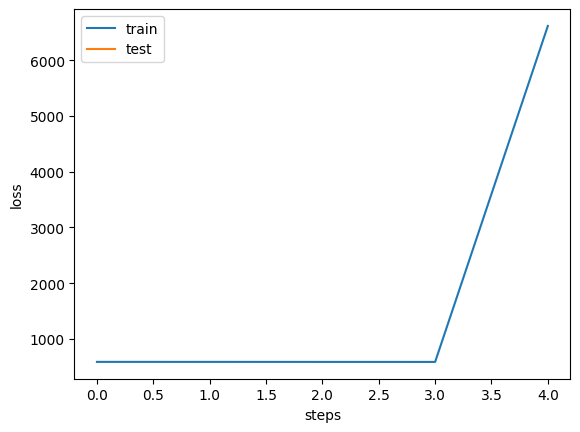

In [129]:
plt.plot(lossi[:])
x = list(range(0,len(lossi), math.ceil(len(lossi)/len(test_lossi))))
plt.plot(x, test_lossi[:len(x)])
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [12]:
#accuracy
correct = 0
for i in range(0,len(test_data)//batch_size):
    current_batch_size = test_data.data[i:i+batch_size].shape[0]
    inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = test_data.targets[i:i+batch_size]    

    out = (tf.Neuron(inp.numpy()) @ h_layer) +  b_layer.broadcast(current_batch_size)
    out_soft = tf.Softmax(out)
    correct += (out_soft.argmax(1) == label.numpy()).sum()


In [13]:
correct/ len(test_data)

0.8321

In [14]:
#accuracy
correct = 0
for i in range(0,len(train_data)//batch_size):
    current_batch_size = train_data.data[i:i+batch_size].shape[0]
    inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = train_data.targets[i:i+batch_size]    

    out = (tf.Neuron(inp.numpy()) @ h_layer) +  b_layer.broadcast(current_batch_size)
    out_soft = tf.Softmax(out)
    correct += (out_soft.argmax(1) == label.numpy()).sum()

In [15]:
correct/ len(train_data)

0.85645

Pred: 1 grad: None, label: 1


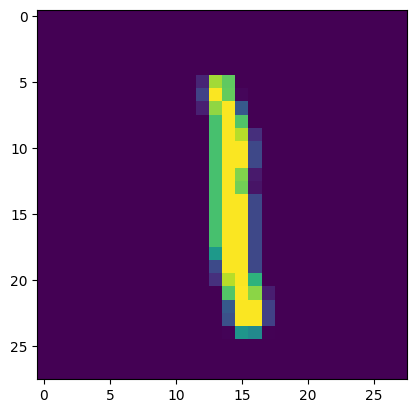

In [36]:
i = random.randint(0,len(test_data))
#inference
inp = test_data.data[i].reshape(1,28*28) / 255
label = test_data.targets[i]    

out = (tf.Neuron(inp.numpy()) @ h_layer) +  b_layer.broadcast(1)
out_soft = tf.Softmax(out)
print(f'Pred: {out_soft.argmax()}, label: {label}')
plt.imshow(test_data.data[i])
